In [1]:
import pandas as pd
import os

In [2]:
cd ..

/Users/alexwarfel/Documents/_active/data-analysis-projects


/Users/alexwarfel/Documents/_active/data-analysis-projects/env/lib/python3.9/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [3]:
from utils.capture_multiple_fred_series import capture_multiple_fred_series
from utils.credentials import credentials

In [4]:
credentials = credentials()

In [5]:
fred_api_key = credentials['FRED API Key']

In [6]:
fred_api_key = credentials['FRED API Key']
combined_data = capture_multiple_fred_series(['FEDFUNDS'],fred_api_key)

In [7]:
# drop records for which all values are NaN
combined_data.dropna(how='all',inplace=True)

<Axes: xlabel='date'>

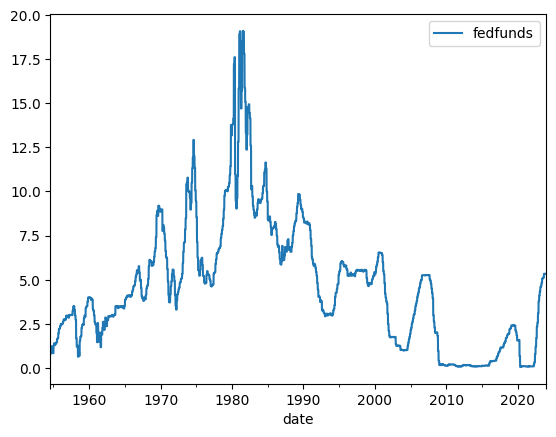

In [8]:
combined_data.plot()

In [9]:
sector_etfs = pd.read_csv(os.path.join('data','sector_etfs.csv'),index_col=0,parse_dates=True)
sector_etfs = sector_etfs.rename(columns=str.lower)
sector_etfs.index = pd.to_datetime(sector_etfs.index)
sector_etfs = sector_etfs[['close','volume','ticker']]
sector_etfs

,close,volume,ticker
timestamp,,,
2018-06-19,49.96,16588.0,XLC
2018-06-20,50.58,189989.0,XLC
2018-06-21,50.27,428740.0,XLC
2018-06-22,50.49,181638.0,XLC
2018-06-23,50.49,181638.0,XLC
...,...,...,...
2023-12-31,475.31,122283149.0,SPY
2024-01-01,475.31,122283149.0,SPY
2024-01-02,472.65,123007793.0,SPY


In [10]:
min_max_index = sector_etfs.copy()
min_max_index['index'] = min_max_index.index
min_max_index = min_max_index.groupby('ticker')['index'].agg(['min', 'max'])
min_max_index.columns = ['min_index', 'max_index']
min_max_index

,min_index,max_index
ticker,,
SPY,1999-11-01,2024-01-04
XLB,1999-11-01,2024-01-04
XLC,2018-06-19,2024-01-04
XLE,1999-11-01,2024-01-04
XLF,1999-11-01,2024-01-04
XLI,1999-11-01,2024-01-04
XLK,1999-11-01,2024-01-04
XLP,1999-11-01,2024-01-04
XLRE,2015-10-08,2024-01-04


Since XLRE and XLC don't have enough history, I'm going to omit them from this analysis. Perhaps they can be added back in later. 

In [11]:
sector_etfs = sector_etfs[~sector_etfs['ticker'].isin(['XLC', 'XLRE'])]
sector_etfs

,close,volume,ticker
timestamp,,,
1999-11-01,28.19,12700.0,XLY
1999-11-02,27.98,3300.0,XLY
1999-11-03,27.75,3100.0,XLY
1999-11-04,28.09,18600.0,XLY
1999-11-05,28.28,7000.0,XLY
...,...,...,...
2023-12-31,475.31,122283149.0,SPY
2024-01-01,475.31,122283149.0,SPY
2024-01-02,472.65,123007793.0,SPY


In [12]:
hlw_estimates = pd.read_csv(os.path.join('data','r_star.csv'),index_col=0,parse_dates=True)
# lowercase all columns, and replace spaces, parentheses, commas, and asterisks with underscores
hlw_estimates.columns = [col.lower().replace(' ','_').replace('(','').replace(')','').replace(',','').replace('*','') for col in hlw_estimates.columns]
hlw_estimates

/var/folders/5x/z5qbg5w927vg45mvfkfy9k5c0000gn/T/ipykernel_2416/323019876.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  hlw_estimates = pd.read_csv(os.path.join('data','r_star.csv'),index_col=0,parse_dates=True)


,us_trend_growth_g_annualized,us_natural_rate_r
Date,,
2061-01-01,4.828759,5.493491
2061-04-01,4.989798,5.682399
2061-07-01,4.923091,5.609036
2061-10-01,4.910719,5.592011
2062-01-01,4.767864,5.431519
...,...,...
2022-04-01,1.728947,0.666278
2022-07-01,1.850930,0.785472
2022-10-01,1.825866,0.717093


In [13]:
# join the hlw_estimates to the combined_data dataframe on the date index
combined_data = combined_data.join(hlw_estimates,how='left')
combined_data

,fedfunds,us_trend_growth_g_annualized,us_natural_rate_r
date,,,
1954-08-01,0.80,NaN,NaN
1954-08-02,0.80,NaN,NaN
1954-08-03,0.80,NaN,NaN
1954-08-04,0.80,NaN,NaN
1954-08-05,0.80,NaN,NaN
...,...,...,...
2024-01-09,5.33,NaN,NaN
2024-01-10,5.33,NaN,NaN
2024-01-11,5.33,NaN,NaN


In [14]:
# remove all rows that have NaN values
combined_data.dropna(inplace=True)
combined_data['economic_throttle'] = combined_data['fedfunds'] - combined_data['us_natural_rate_r']
combined_data.to_csv(os.path.join('data','economic_throttle_data.csv'))
combined_data

,fedfunds,us_trend_growth_g_annualized,us_natural_rate_r,economic_throttle
date,,,,
1974-01-01,9.95,3.502157,4.057559,5.892441
1974-04-01,9.35,3.461613,4.279150,5.070850
1974-07-01,11.93,3.154049,4.116700,7.813300
1974-10-01,11.34,3.069884,3.975118,7.364882
1975-01-01,8.53,2.784576,3.465921,5.064079
...,...,...,...,...
2022-04-01,0.20,1.728947,0.666278,-0.466278
2022-07-01,1.21,1.850930,0.785472,0.424528
2022-10-01,2.56,1.825866,0.717093,1.842907


<Axes: xlabel='date'>

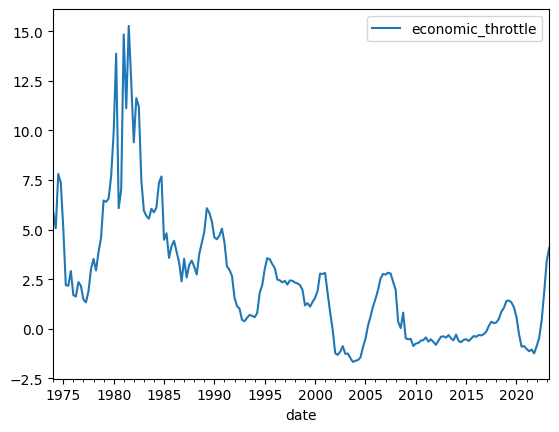

In [15]:
combined_data.plot(y='economic_throttle')

In [16]:
economic_throttle_data = combined_data['economic_throttle']

number_of_months = int(((12*2.1)/4))

fed_funds_rate_rolling_max = economic_throttle_data.rolling(number_of_months, min_periods=1).max()

fed_funds_rate_reversed = economic_throttle_data.iloc[::-1]
fed_funds_rate_rolling_max_forward_reversed = fed_funds_rate_reversed.rolling(number_of_months, min_periods=1).max()

fed_funds_rate_rolling_max_forward = fed_funds_rate_rolling_max_forward_reversed.iloc[::-1]

fed_funds_rate_peaks = economic_throttle_data[(economic_throttle_data == fed_funds_rate_rolling_max) & (economic_throttle_data == fed_funds_rate_rolling_max_forward)]
fed_funds_rate_peaks

date
1974-07-01     7.813300
1981-07-01    15.272418
1984-10-01     7.681051
1989-04-01     6.081553
1995-04-01     3.561048
2001-01-01     2.813563
2007-04-01     2.825573
2011-01-01    -0.434492
2014-01-01    -0.292756
2019-04-01     1.425222
2023-04-01     4.081180
Name: economic_throttle, dtype: float64

In [17]:
fed_funds_rate_peaks = pd.DataFrame(fed_funds_rate_peaks)
fed_funds_rate_peaks.columns = ['peaks']
fed_funds_rate_peaks['peaks'] = fed_funds_rate_peaks['peaks'].astype('float64')

fed_funds_rate_peaks = fed_funds_rate_peaks[fed_funds_rate_peaks['peaks'].notnull()]
fed_funds_rate_peaks

,peaks
date,
1974-07-01,7.813300
1981-07-01,15.272418
1984-10-01,7.681051
1989-04-01,6.081553
1995-04-01,3.561048
2001-01-01,2.813563
2007-04-01,2.825573
2011-01-01,-0.434492
2014-01-01,-0.292756


In [18]:
mask = pd.Series([False] * len(fed_funds_rate_peaks), index=fed_funds_rate_peaks.index)

for i in range(len(fed_funds_rate_peaks)):
    if i == 0 or fed_funds_rate_peaks['peaks'].iloc[i] != fed_funds_rate_peaks['peaks'].iloc[i-1]:
        mask.iloc[i] = True

result_df = fed_funds_rate_peaks[mask]

result_df

,peaks
date,
1974-07-01,7.813300
1981-07-01,15.272418
1984-10-01,7.681051
1989-04-01,6.081553
1995-04-01,3.561048
2001-01-01,2.813563
2007-04-01,2.825573
2011-01-01,-0.434492
2014-01-01,-0.292756


In [19]:
sector_etfs.loc[(sector_etfs.index >= '2013-12-29') & (sector_etfs.index <= '2014-01-05')]


,close,volume,ticker
timestamp,,,
2013-12-29,66.27,3142500.0,XLY
2013-12-30,66.57,2116100.0,XLY
2013-12-31,66.83,3675800.0,XLY
2014-01-01,66.83,3675800.0,XLY
2014-01-02,66.52,4331900.0,XLY
...,...,...,...
2014-01-01,184.69,86247638.0,SPY
2014-01-02,182.92,119636836.0,SPY
2014-01-03,182.89,81390502.0,SPY


In [20]:
# make sure the sector_etfs and result_df indexes are both datetime objects
sector_etfs.index = pd.to_datetime(sector_etfs.index)
result_df.index = pd.to_datetime(result_df.index)

combined_etf_and_economic_data = sector_etfs.merge(result_df,how='left',left_index=True,right_index=True)
combined_etf_and_economic_data.dropna(subset=['peaks'], inplace=True)
combined_etf_and_economic_data.reset_index(inplace=True)
combined_etf_and_economic_data

,timestamp,close,volume,ticker,peaks
0,2001-01-01,25.5900,13900.0,XLY,2.813563
1,2001-01-01,28.5600,34400.0,XLP,2.813563
2,2001-01-01,33.1900,185400.0,XLE,2.813563
3,2001-01-01,29.5000,687300.0,XLF,2.813563
4,2001-01-01,27.2500,34100.0,XLV,2.813563
5,2001-01-01,31.2500,15900.0,XLI,2.813563
6,2001-01-01,21.4200,55900.0,XLB,2.813563
7,2001-01-01,31.3100,3387700.0,XLK,2.813563
8,2001-01-01,33.1900,18600.0,XLU,2.813563
9,2001-01-01,131.1875,8774600.0,SPY,2.813563


In [21]:
sector_etfs.reset_index(inplace=True)
sector_etfs['timestamp'] = pd.to_datetime(sector_etfs['timestamp'])
sector_etfs

/var/folders/5x/z5qbg5w927vg45mvfkfy9k5c0000gn/T/ipykernel_2416/1260928146.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sector_etfs['timestamp'] = pd.to_datetime(sector_etfs['timestamp'])


,timestamp,close,volume,ticker
0,1999-11-01,28.19,12700.0,XLY
1,1999-11-02,27.98,3300.0,XLY
2,1999-11-03,27.75,3100.0,XLY
3,1999-11-04,28.09,18600.0,XLY
4,1999-11-05,28.28,7000.0,XLY
...,...,...,...,...
88305,2023-12-31,475.31,122283149.0,SPY
88306,2024-01-01,475.31,122283149.0,SPY
88307,2024-01-02,472.65,123007793.0,SPY
88308,2024-01-03,468.79,103585866.0,SPY


In [22]:
economic_data_timestamps = combined_etf_and_economic_data[['timestamp','ticker']].drop_duplicates().values.tolist()

In [23]:
unioned_data = pd.DataFrame()

# loop through each combination of timestamp and ticker in the economic_data_timestamps list
for timestamp, ticker in economic_data_timestamps:
    # convert timestamp to datetime object
    timestamp = pd.to_datetime(timestamp)
    # create a dataframe of the timestamp and ticker combination saving the next 365 days of ticker data for each respective ticker
    sector_etf_data = sector_etfs.loc[(sector_etfs['timestamp'] >= timestamp) & (sector_etfs['timestamp'] <= timestamp + pd.Timedelta(days=(365*2))) & (sector_etfs['ticker'] == ticker)].copy()

    sector_etf_data.rename(columns={'timestamp':'future_timestamp','close':'future_close','volume':'future_volume','ticker':'ticker_for_join'},inplace=True)
    sector_etf_data['timestamp_for_join'] = timestamp

    # add the sector_etf_data dataframe to the unioned_data dataframe without using append
    unioned_data = pd.concat([unioned_data,sector_etf_data],axis=0,ignore_index=True)

unioned_data

,future_timestamp,future_close,future_volume,ticker_for_join,timestamp_for_join
0,2001-01-01,25.59,13900.0,XLY,2001-01-01
1,2001-01-02,25.55,167100.0,XLY,2001-01-01
2,2001-01-03,27.56,1034400.0,XLY,2001-01-01
3,2001-01-04,27.95,259900.0,XLY,2001-01-01
4,2001-01-05,27.03,91300.0,XLY,2001-01-01
...,...,...,...,...,...
39335,2023-12-31,475.31,122283149.0,SPY,2023-04-01
39336,2024-01-01,475.31,122283149.0,SPY,2023-04-01
39337,2024-01-02,472.65,123007793.0,SPY,2023-04-01
39338,2024-01-03,468.79,103585866.0,SPY,2023-04-01


In [24]:
total_combined_data = combined_etf_and_economic_data.merge(unioned_data,how='left',left_on=['timestamp','ticker'],right_on=['timestamp_for_join','ticker_for_join'])
total_combined_data['cumulative_return'] = total_combined_data['future_close'] / total_combined_data['close'] - 1
total_combined_data['rownumber'] = total_combined_data.groupby(['timestamp','ticker']).cumcount() + 1
total_combined_data

,timestamp,close,volume,ticker,peaks,future_timestamp,future_close,future_volume,ticker_for_join,timestamp_for_join,cumulative_return,rownumber
0,2001-01-01,25.59,13900.0,XLY,2.813563,2001-01-01,25.59,13900.0,XLY,2001-01-01,0.000000,1
1,2001-01-01,25.59,13900.0,XLY,2.813563,2001-01-02,25.55,167100.0,XLY,2001-01-01,-0.001563,2
2,2001-01-01,25.59,13900.0,XLY,2.813563,2001-01-03,27.56,1034400.0,XLY,2001-01-01,0.076983,3
3,2001-01-01,25.59,13900.0,XLY,2.813563,2001-01-04,27.95,259900.0,XLY,2001-01-01,0.092224,4
4,2001-01-01,25.59,13900.0,XLY,2.813563,2001-01-05,27.03,91300.0,XLY,2001-01-01,0.056272,5
...,...,...,...,...,...,...,...,...,...,...,...,...
39335,2023-04-01,409.39,112062624.0,SPY,4.081180,2023-12-31,475.31,122283149.0,SPY,2023-04-01,0.161020,275
39336,2023-04-01,409.39,112062624.0,SPY,4.081180,2024-01-01,475.31,122283149.0,SPY,2023-04-01,0.161020,276
39337,2023-04-01,409.39,112062624.0,SPY,4.081180,2024-01-02,472.65,123007793.0,SPY,2023-04-01,0.154523,277
39338,2023-04-01,409.39,112062624.0,SPY,4.081180,2024-01-03,468.79,103585866.0,SPY,2023-04-01,0.145094,278


In [25]:
total_combined_data.to_csv(os.path.join('data','total_combined_data.csv'),index=False)

In [26]:
filtered_total_combined_data = total_combined_data.loc[total_combined_data['timestamp'] == pd.to_datetime('2001-01-01')]
filtered_total_combined_data

,timestamp,close,volume,ticker,peaks,future_timestamp,future_close,future_volume,ticker_for_join,timestamp_for_join,cumulative_return,rownumber
0,2001-01-01,25.5900,13900.0,XLY,2.813563,2001-01-01,25.59,13900.0,XLY,2001-01-01,0.000000,1
1,2001-01-01,25.5900,13900.0,XLY,2.813563,2001-01-02,25.55,167100.0,XLY,2001-01-01,-0.001563,2
2,2001-01-01,25.5900,13900.0,XLY,2.813563,2001-01-03,27.56,1034400.0,XLY,2001-01-01,0.076983,3
3,2001-01-01,25.5900,13900.0,XLY,2.813563,2001-01-04,27.95,259900.0,XLY,2001-01-01,0.092224,4
4,2001-01-01,25.5900,13900.0,XLY,2.813563,2001-01-05,27.03,91300.0,XLY,2001-01-01,0.056272,5
...,...,...,...,...,...,...,...,...,...,...,...,...
7305,2001-01-01,131.1875,8774600.0,SPY,2.813563,2002-12-28,87.38,22205700.0,SPY,2001-01-01,-0.333930,727
7306,2001-01-01,131.1875,8774600.0,SPY,2.813563,2002-12-29,87.38,22205700.0,SPY,2001-01-01,-0.333930,728
7307,2001-01-01,131.1875,8774600.0,SPY,2.813563,2002-12-30,88.11,29968000.0,SPY,2001-01-01,-0.328366,729
7308,2001-01-01,131.1875,8774600.0,SPY,2.813563,2002-12-31,88.23,34036600.0,SPY,2001-01-01,-0.327451,730


In [27]:
# average the cumulative_return partitioned by ticker and rownumber
averaged_total_combined_data = total_combined_data.groupby(['ticker','rownumber']).agg({'cumulative_return':['mean','count']}).reset_index()

# collapse the multi-index columns into a single index by joining the column names with an underscore IF the column is a multi index
averaged_total_combined_data.columns = ['_'.join(col) if col[1]!='' else col[0] for col in averaged_total_combined_data.columns.values]

averaged_total_combined_data


,ticker,rownumber,cumulative_return_mean,cumulative_return_count
0,SPY,1,0.000000,6
1,SPY,2,-0.004345,6
2,SPY,3,0.007905,6
3,SPY,4,0.005669,6
4,SPY,5,0.001838,6
...,...,...,...,...
7305,XLY,727,0.058204,5
7306,XLY,728,0.058895,5
7307,XLY,729,0.057118,5
7308,XLY,730,0.055510,5


<Axes: xlabel='rownumber'>

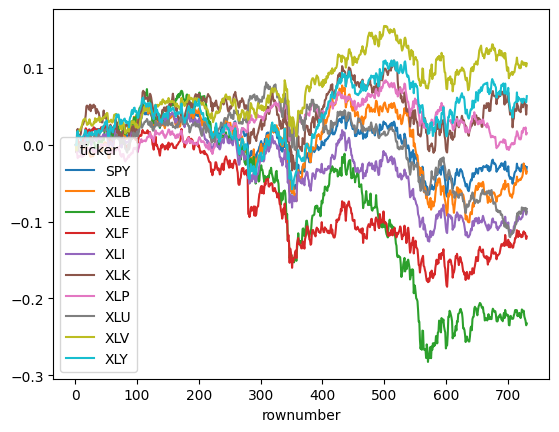

In [28]:
# plot the cumulative_return by rownumber and ticker
averaged_total_combined_data.pivot(index='rownumber',columns='ticker',values='cumulative_return_mean').plot()

In [31]:
# pivot the averaged_total_combined_data such that each ticker is a column and the cumulative return is the value
averaged_total_combined_data_pivoted = averaged_total_combined_data.pivot(index='rownumber',columns='ticker',values='cumulative_return_mean')
# rename the rownumber column to "Days since peak restrictive monetary policy"
averaged_total_combined_data_pivoted.index.name = 'Days since peak restrictive monetary policy'

# multiple all values by 100, and round to the second decimal place
averaged_total_combined_data_pivoted = averaged_total_combined_data_pivoted * 100
averaged_total_combined_data_pivoted = averaged_total_combined_data_pivoted.round(2)

# create a dictionary of the tickers and the sector names
ticker_sector_dict = {'XLY':'Consumer discretionary','XLP':'Consumer staples','XLE':'Energy','XLF':'Financials','XLV':'Health care','XLI':'Industrials','XLB':'Materials','XLK':'Technology','XLU':'Utilities','SPY':'S&P 500'}

# rename the columns of the averaged_total_combined_data_pivoted dataframe using the ticker_sector_dict
averaged_total_combined_data_pivoted.columns = [ticker_sector_dict[col] for col in averaged_total_combined_data_pivoted.columns]

averaged_total_combined_data_pivoted.to_csv(os.path.join('data','averaged_total_combined_data_pivoted.csv'))